In [1]:
import numpy as np 
import pandas as pd
import random
import os
import tensorflow as tf
import json
import nltk
from tensorflow import keras
from keras.models import Sequential
from keras.utils import pad_sequences 
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from keras.models import Model
import matplotlib.pyplot as plt
import api

    IMPORTING THE DATA


In [2]:
#importing the dataset
with open('intents.json') as content:
    data = json.load(content)

In [3]:
#getting the data to lists
tags = []
inputs = []
responses = {}
for intent in data['intents']:
    responses[intent['tag']] = intent['responses']
    for lines in intent['patterns']:
        inputs.append(lines)
        tags.append(intent['tag'])

In [4]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                    "tags":tags})

In [5]:
#printing the data
data

,inputs,tags
0,Hi,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting
...,...,...
75,get me news updates?,news
76,todays news,news
77,top headlines,news
78,current news,news


    DATA PREPROCESSING

In [6]:
#removing puntuation
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))

In [7]:
data

,inputs,tags
0,hi,greeting
1,how are you,greeting
2,is anyone there,greeting
3,hello,greeting
4,good day,greeting
...,...,...
75,get me news updates,news
76,todays news,news
77,top headlines,news
78,current news,news


    TOKENIZATION

Tokenizer assigns a unique token to each distinct word and padding is done to get all the data together 

In [8]:
#tokenize the data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

In [9]:
#apply padding
x_train = pad_sequences(train)

In [10]:
#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [11]:
input_shape = x_train.shape[1]
input_shape

8

In [12]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
length = le.classes_.shape[0]
print("Length : ", length)

number of unique words :  100
Length :  20


In [13]:
num_classes = len(tags)
num_classes

80

    NEURAL NETWORKS

The main part is training the neural network. The outputs of the embedding layer is the inpu tof the recurrent layer with LSTM gate,then, output is flattened and a regular dense layer is used witha softmax activation function

In [14]:
#creating the model
model = Sequential()
model.add(Input(shape = (input_shape)))
model.add(Embedding(vocabulary+1, 10))
model.add(GlobalMaxPooling1D())
#model.add(LSTM(10,return_sequences = True))
model.add(Flatten())
model.add(Dense(length, activation="softmax"))


In [15]:
#compiling the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [16]:
#training the model
new_model = model.fit(x_train, y_train, epochs= 500)

Epoch 1/500
3/3 [==============================] - 2s 8ms/step - loss: 2.9952 - accuracy: 0.0500
Epoch 2/500
3/3 [==============================] - 0s 16ms/step - loss: 2.9913 - accuracy: 0.0625
Epoch 3/500
3/3 [==============================] - 0s 9ms/step - loss: 2.9876 - accuracy: 0.0750
Epoch 4/500
3/3 [==============================] - 0s 6ms/step - loss: 2.9845 - accuracy: 0.0875
Epoch 5/500
3/3 [==============================] - 0s 7ms/step - loss: 2.9812 - accuracy: 0.0875
Epoch 6/500
3/3 [==============================] - 0s 7ms/step - loss: 2.9781 - accuracy: 0.1125
Epoch 7/500
3/3 [==============================] - 0s 7ms/step - loss: 2.9750 - accuracy: 0.1500
Epoch 8/500
3/3 [==============================] - 0s 7ms/step - loss: 2.9719 - accuracy: 0.1500
Epoch 9/500
3/3 [==============================] - 0s 7ms/step - loss: 2.9689 - accuracy: 0.1500
Epoch 10/500
3/3 [==============================] - 0s 8ms/step - loss: 2.9658 - accuracy: 0.1875
Epoch 11/500
3/3 [==========

     MODEL ANALYSIS

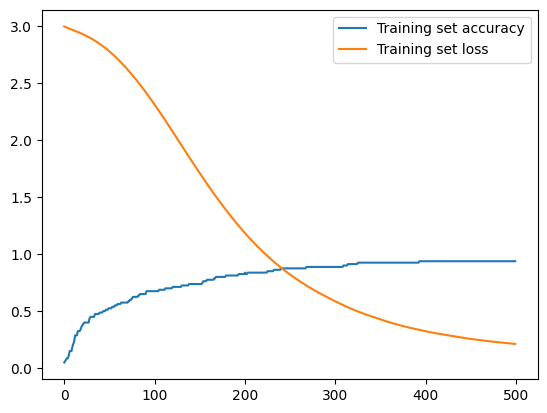

In [17]:
#plotting model accuracy
plt.plot(new_model.history['accuracy'], label = "Training set accuracy")
plt.plot(new_model.history['loss'], label = "Training set loss")
plt.legend()

In [18]:
while True:
    text = []
    inp = input("User : ")
    print("User : " + inp)
    inp = [letters.lower() for letters in inp if letters not in string.punctuation]
    inp = ''.join(inp)
    text.append(inp)

    #tokenization and padding
    inp = tokenizer.texts_to_sequences(text)
    inp = np.array(inp).reshape(-1)
    inp = pad_sequences([inp], input_shape)

    #output from model
    output = model.predict(inp)
    output = output.argmax()

    response_tag = le.inverse_transform([output])[0]

    print("Danica : ", random.choice(responses[response_tag]))
    if response_tag == "news":
        api.news("india")
    if response_tag == "weather":
        loc = input("Location : ")
        api.weather(loc)
    if response_tag == "joke":
        api.jokes()
    if response_tag == "goodbye":
        break


User : weather
1/1 [==============================] - 0s 389ms/step
Danica :  Fetching weather updates ...
Temperature :  283.87 F
User : jokes
1/1 [==============================] - 0s 40ms/step
Danica :  Getting news ...
0. India to host virtual summit of over 120 developing nations
1. Exclusive-Renault considers making mass-market EVs in India -sources
2. Not a setback for DPAP: Azad on his party leaders rejoining Cong
3. Exclusive: Renault considers making mass-market EVs in India -sources
4. Geen Nederlandse finale: Botic van de Zandschulp kan goede voorbeeld Tallon Griekspoor niet volgen
User : jokes
1/1 [==============================] - 0s 62ms/step
Danica :  Getting news ...
0. India to host virtual summit of over 120 developing nations
1. Exclusive-Renault considers making mass-market EVs in India -sources
2. Not a setback for DPAP: Azad on his party leaders rejoining Cong
3. Exclusive: Renault considers making mass-market EVs in India -sources
4. Geen Nederlandse finale: Bot